In [136]:
#tensorflow 2.2.2
#others newest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import random
import os
import tqdm.keras as tk
from keras_tqdm import TQDMNotebookCallback
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [137]:
train_path = "./new_train/new_train"
test_path = "./new_val_in/new_val_in"

In [138]:
data_list = glob(os.path.join(train_path, '*'))
random.shuffle(data_list)
print(int(len(data_list)*1))
data_list = data_list[:len(data_list)]
print(int(len(data_list)*1))

train_list = data_list[:int(len(data_list)*0.9)-47]
valid_list = data_list[int(len(data_list)*0.9)+95:]
print(len(train_list))
print(len(valid_list))

205942
205942
185300
20500


In [139]:
batch_size = 100
epochs = 20
latent_dim = 256
num_encoder_tokens = 2
num_decoder_tokens = 2

In [140]:
shit = np.array([1,2,3,4,5,])
shit[:-1]

array([1, 2, 3, 4])

In [141]:
def train_generator(train_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 2), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 2), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 2), dtype='float32')
        for i in range(batch_size):
            train_path = train_list[index]
            with open(train_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                
                input_data = data['p_in'][idx,:,:]    
                encoder_input_data[i,:,:] = input_data
                
                last_input = input_data[len(input_data)-1]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                decoder_input_data[i,1:,:] = output_data[:-1]
                
                decoder_target_data[i,:,:] = output_data
            index += 1
        if index == len(train_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

        
def valid_generator(valid_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 2), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 2), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 2), dtype='float32')
        for i in range(batch_size):
            valid_path = valid_list[index]
            with open(valid_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                
                input_data = data['p_in'][idx,:,:]    
                encoder_input_data[i,:,:] = input_data
                
                last_input = input_data[len(input_data)-1]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                decoder_input_data[i,1:,:] = output_data[:-1]
                
                decoder_target_data[i,:,:] = output_data
            index += 1
        if index == len(valid_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

In [142]:
#encoder portion
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, activation="relu")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#decoder portion
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, activation="relu")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [143]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 256), (None, 265216      input_19[0][0]                   
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, None, 256),  265216      input_20[0][0]                   
                                                                 lstm_16[0][1]             

In [144]:
train_gen = train_generator(train_list,100)
valid_gen = valid_generator(valid_list,100)

In [145]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model.compile(optimizer='adam', loss=root_mean_squared_error)
checkpointer = ModelCheckpoint(filepath='./lstm_seqtoseq_relu_weights.hdf5', verbose=2, save_best_only=True, mode='min')


In [ ]:
hist = model.fit(train_gen,
                        verbose=2,
                        epochs=10,
                        validation_data=valid_gen,
                        steps_per_epoch=(len(train_list)/100),
                        validation_steps=(len(valid_list)/100),
                        callbacks=[checkpointer, TQDMNotebookCallback()]
                        )


Epoch 1/10

Epoch 00001: val_loss did not improve from 7.72912
1853/1853 - 349s - loss: 9.5623 - val_loss: 10.1564


Epoch 2/10

Epoch 00002: val_loss did not improve from 7.72912
1853/1853 - 386s - loss: 8.7440 - val_loss: 9.8327


Epoch 3/10


drawing the training process...


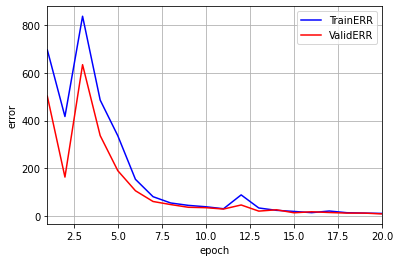

In [147]:
TrainERR=hist.history['loss']
ValidERR=hist.history['val_loss']
# print('@%f, Minimun error:%f, at iteration: %i' % (hist.history['val_loss'][epoch-1], np.min(np.asarray(ValidERR)),np.argmin(np.asarray(ValidERR))+1))
print('drawing the training process...')
plt.figure(2)
plt.plot(range(1,epochs+1),TrainERR,'b',label='TrainERR')
plt.plot(range(1,epochs+1),ValidERR,'r',label='ValidERR')
plt.xlim([1,epochs])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
fig1 = plt.gcf()
fig1.savefig('lstm20epochs_relu.png', dpi=100)
plt.show()

In [148]:
#encoder model inference
encoder_model = Model(encoder_inputs, encoder_states)

#decoder model inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [149]:
encoder_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None, 2)]         0         
_________________________________________________________________
lstm_16 (LSTM)               [(None, 256), (None, 256) 265216    
Total params: 265,216
Trainable params: 265,216
Non-trainable params: 0
_________________________________________________________________


In [150]:
decoder_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, None, 256),  265216      input_20[0][0]                   
                                                                 input_21[0][0]            

In [175]:
def decode_sequence(input_seq):
    #input seq is a scene 
    # Encode the input as state vectors.
#     print("input seq shape is ",input_seq.shape)
    input_shaped = np.empty((1,19,2))
    input_shaped[0,:,:] = input_seq
#     encoder_model.summary()
#     input_shaped = np.reshape(input_seq, (input_seq.shape[0], 1, input_seq.shape[1]))
#     print("inpiut shaped is ", input_shaped)
    states_value = encoder_model.predict(input_shaped)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0,0,:] = input_seq[len(input_seq)-1] 

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    index = 0
    decoded_sentence = ''
    decoded_array = np.empty((30,2))
    while index < 30:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        
#         print("output tokens are ", output_tokens[0][0])
        
        # Sample a token
        decoded_array[index,:] = output_tokens[0][0]

        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, :] = output_tokens
        # Update states
        states_value = [h, c]
    
        index += 1
    
    return decoded_array

In [176]:
columns = []
columns.append("ID")
for i in range(60):
    num = "v"+str(i+1)
    columns.append(num)
    
df = pd.DataFrame(columns=columns)

In [177]:
#testing portion
test_list = glob(os.path.join(test_path, '*'))
print(len(test_list))

for x in tqdm(test_list):
    test_x = np.empty((30,2))
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,:]
        
        test_x = decode_sequence(input_data)
        flat = test_x.flatten()
        for elem in flat:
            new_row.append(elem)
        df_length = len(df)
        df.loc[df_length] = new_row
        











  0%|          | 0/3200 [00:00<?, ?it/s]









  0%|          | 1/3200 [00:00<08:11,  6.51it/s]

3200












  0%|          | 2/3200 [00:00<07:49,  6.81it/s]









  0%|          | 3/3200 [00:00<07:27,  7.15it/s]









  0%|          | 4/3200 [00:00<07:04,  7.53it/s]









  0%|          | 5/3200 [00:00<07:01,  7.58it/s]









  0%|          | 6/3200 [00:00<06:57,  7.66it/s]









  0%|          | 7/3200 [00:00<06:54,  7.70it/s]









  0%|          | 8/3200 [00:01<06:49,  7.79it/s]









  0%|          | 9/3200 [00:01<06:43,  7.91it/s]









  0%|          | 10/3200 [00:01<06:39,  7.98it/s]









  0%|          | 11/3200 [00:01<06:37,  8.02it/s]









  0%|          | 12/3200 [00:01<06:42,  7.93it/s]









  0%|          | 13/3200 [00:01<06:42,  7.91it/s]









  0%|          | 14/3200 [00:01<06:42,  7.92it/s]









  0%|          | 15/3200 [00:01<06:43,  7.89it/s]









  0%|          | 16/3200 [00:02<06:45,  7.86it/s]









  1%|          | 17/3200 [00:02<06:40,  7.95it/s]









  1%|          | 18/3200 [00:02<06:39,  7.96it/s]






In [183]:
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,34189,565.006226,563.199890,601.116516,544.998047,273.115814,378.706146,347.217590,323.433563,372.560883,...,374.526337,416.583893,373.969879,416.626770,373.425934,416.668701,372.894348,416.709656,372.374817,416.749725
1,1454,577.196655,1232.851929,581.614685,1242.699951,582.537537,1243.632446,590.127991,1247.790039,593.178040,...,578.192139,1239.487305,578.133301,1239.171143,578.219482,1238.821167,578.471558,1238.435547,579.141846,1237.821045
2,32404,593.529541,1526.452148,588.652466,1529.600708,595.790833,1526.908569,595.061890,1524.582886,597.697815,...,597.272339,1522.318115,597.734558,1522.142822,598.394348,1521.891113,599.273132,1521.559814,600.391418,1521.150513
3,33991,418.257019,1138.536621,415.657318,1140.103760,420.720764,1138.536499,419.959351,1137.603882,424.422974,...,426.276703,1139.731201,426.701569,1139.710938,427.271667,1139.627808,428.003845,1139.479492,428.913879,1139.266724
4,30427,589.701965,616.129456,631.376953,571.724182,261.071198,416.818146,369.531158,389.453217,388.301788,...,395.361511,482.312042,394.751282,482.363678,394.154419,482.414154,393.570557,482.463562,392.999542,482.511871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717,953.905090,-61.819126,1390.802856,282.865662,1300.979492,198.788132,1439.071655,275.444183,1418.395630,...,1504.617432,359.954865,1503.682739,361.511810,1501.926147,362.670074,1498.309937,364.023621,1493.818237,364.950928
3196,5734,1725.325317,427.468018,1897.241821,570.185303,1425.896240,228.818634,1906.909546,638.988098,2164.379639,...,1949.143677,615.693298,1950.127075,618.103455,1951.126465,620.262634,1951.883301,622.049500,1952.272461,623.210693
3197,33829,664.030701,577.875183,776.487915,610.385925,551.543152,557.604431,605.364990,501.644836,654.826050,...,658.834961,609.196838,658.004150,609.033508,657.275452,608.898804,656.646790,608.792236,656.116150,608.712830
3198,4515,582.092285,1410.693115,579.826782,1417.190186,585.068970,1416.856445,589.564758,1417.572021,591.121338,...,586.847656,1410.204590,587.177795,1409.964355,587.694580,1409.648804,588.418518,1409.255615,589.369141,1408.786743


In [184]:
# vizualizing testing data frame

columns_test = []
columns_test.append("ID")
for i in range(38):
    num = "v"+str(i+1)
    columns_test.append(num)
    
df_test = pd.DataFrame(columns=columns_test)


for x in test_list:
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,:]
        for i in range(38):
            new_row.append(input_data.flatten()[i])
        df_length = len(df_test)
        df_test.loc[df_length] = new_row


In [185]:
df_test

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38
0,34189.0,595.562073,936.528992,595.544006,935.963928,595.649536,936.135559,595.667480,935.907166,595.707275,...,596.247437,933.134216,596.408813,932.617249,596.376892,932.458801,596.398865,932.383728,596.435852,932.086731
1,1454.0,579.748535,1236.775146,579.938965,1236.378784,580.365906,1235.755371,580.250061,1235.585815,580.636536,...,582.202637,1229.476196,582.441162,1228.873901,582.233643,1228.338623,582.358765,1227.714478,582.552185,1227.146851
2,32404.0,596.773865,1526.008545,596.632812,1526.094360,596.576294,1526.078125,596.498291,1526.105225,596.269348,...,593.871521,1525.996704,593.444214,1525.877930,592.983887,1525.745117,592.521118,1525.561646,592.052429,1525.351685
3,33991.0,416.036377,1131.377930,415.903534,1131.828003,415.764526,1132.141724,415.624969,1132.613525,415.485992,...,413.496155,1136.546021,413.229736,1136.827271,412.953491,1137.106201,412.656830,1137.415649,412.440948,1137.703003
4,30427.0,591.568970,986.132019,591.628113,985.414978,591.787476,984.686584,591.843811,984.013428,591.922363,...,592.989380,975.482605,592.937866,974.617676,593.038269,973.842896,593.211975,973.422119,593.310730,972.728210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717.0,1875.832397,471.821625,1876.988770,472.846069,1878.359009,473.901123,1879.551514,474.995544,1880.836060,...,1893.428467,486.367584,1894.691895,487.410950,1895.904175,488.400177,1897.126709,489.408905,1898.337891,490.422180
3196,5734.0,2069.424072,635.513184,2068.171631,634.562622,2066.786621,633.569031,2065.407471,632.559387,2064.130371,...,2050.308594,621.376709,2048.978516,620.367310,2047.582764,619.339417,2046.292236,618.321838,2044.849243,617.266418
3197,33829.0,726.628113,909.115906,726.607422,909.657166,726.652161,909.966309,726.634827,909.686401,726.640259,...,727.459900,912.470154,727.510315,912.951233,727.566162,913.033325,727.508850,913.745483,727.478943,914.257568
3198,4515.0,582.553650,1419.214355,582.546326,1418.776367,582.498047,1418.246216,582.581909,1417.869873,582.607849,...,582.132080,1412.069458,582.254089,1410.913574,582.018677,1410.472656,582.125854,1409.070923,582.208496,1408.635132


In [186]:
df['ID'] = df['ID'].map(round)

In [187]:
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,34189,565.006226,563.199890,601.116516,544.998047,273.115814,378.706146,347.217590,323.433563,372.560883,...,374.526337,416.583893,373.969879,416.626770,373.425934,416.668701,372.894348,416.709656,372.374817,416.749725
1,1454,577.196655,1232.851929,581.614685,1242.699951,582.537537,1243.632446,590.127991,1247.790039,593.178040,...,578.192139,1239.487305,578.133301,1239.171143,578.219482,1238.821167,578.471558,1238.435547,579.141846,1237.821045
2,32404,593.529541,1526.452148,588.652466,1529.600708,595.790833,1526.908569,595.061890,1524.582886,597.697815,...,597.272339,1522.318115,597.734558,1522.142822,598.394348,1521.891113,599.273132,1521.559814,600.391418,1521.150513
3,33991,418.257019,1138.536621,415.657318,1140.103760,420.720764,1138.536499,419.959351,1137.603882,424.422974,...,426.276703,1139.731201,426.701569,1139.710938,427.271667,1139.627808,428.003845,1139.479492,428.913879,1139.266724
4,30427,589.701965,616.129456,631.376953,571.724182,261.071198,416.818146,369.531158,389.453217,388.301788,...,395.361511,482.312042,394.751282,482.363678,394.154419,482.414154,393.570557,482.463562,392.999542,482.511871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717,953.905090,-61.819126,1390.802856,282.865662,1300.979492,198.788132,1439.071655,275.444183,1418.395630,...,1504.617432,359.954865,1503.682739,361.511810,1501.926147,362.670074,1498.309937,364.023621,1493.818237,364.950928
3196,5734,1725.325317,427.468018,1897.241821,570.185303,1425.896240,228.818634,1906.909546,638.988098,2164.379639,...,1949.143677,615.693298,1950.127075,618.103455,1951.126465,620.262634,1951.883301,622.049500,1952.272461,623.210693
3197,33829,664.030701,577.875183,776.487915,610.385925,551.543152,557.604431,605.364990,501.644836,654.826050,...,658.834961,609.196838,658.004150,609.033508,657.275452,608.898804,656.646790,608.792236,656.116150,608.712830
3198,4515,582.092285,1410.693115,579.826782,1417.190186,585.068970,1416.856445,589.564758,1417.572021,591.121338,...,586.847656,1410.204590,587.177795,1409.964355,587.694580,1409.648804,588.418518,1409.255615,589.369141,1408.786743


In [188]:
df.to_csv(r'./submissions_lstm.csv', index = False, header=True)